In [1]:
import pandas as pd
import os
import numpy as np
from nltk.tokenize import word_tokenize

## Open correction and lexicon files

In [2]:
from pandas import concat


with open('issues.csv') as f:
    data = pd.read_csv(f)

lexicon_path = 'false-negatives_vs_lexicon'
lexicon = dict()

for filename in os.listdir(lexicon_path):
    with open(os.path.join(lexicon_path, filename), 'r') as f:
        lexicon[filename.split('.')[0]] = f.read().split("\n")

taxa = concat([pd.Series(lexicon[col]) if col.endswith('taxa') else pd.Series([]) for col in lexicon.keys()])
habitat = concat([pd.Series(lexicon[col]) if col.endswith('habitat') else pd.Series([]) for col in lexicon.keys()])

/tmp/ipykernel_53686/2302221639.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  taxa = concat([pd.Series(lexicon[col]) if col.endswith('taxa') else pd.Series([]) for col in lexicon.keys()])
/tmp/ipykernel_53686/2302221639.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  habitat = concat([pd.Series(lexicon[col]) if col.endswith('habitat') else pd.Series([]) for col in lexicon.keys()])


## Connect NER results with ontology lexicon

In [3]:
## define correspondence functions

def equivalent_to(a,b):
    if str(a).strip() == str(b).strip():
        return True
    else:    
        return False

def narrower_than(a,b):
    if str(a).strip() in str(b).strip():
        return True
    else:    
        return False
    
def wider_than(a,b):
    if str(b).strip() in str(a).strip():
         return True
    else:    
        return False

def token_correspondence(a,b): # e.g. X Y vs X Z
    for token in word_tokenize(str(a)):
        if equivalent_to(token,b):
            return True
    return False
        
def no_correspondence(a,b):
    if (not token_correspondence(a,b) and
        not wider_than(a,b) and
        not narrower_than(a,b) and
        not equivalent_to(a,b)):
        return True
    else:    
        return False


In [4]:
correspondence_types = {'narrower_than_':narrower_than,
                        'wider_than_':wider_than,
                        'equivalent_to_':equivalent_to,
                        'no_correspondence_to_':no_correspondence,
                        'token_correspondence_to_':token_correspondence}
term_classes = {'taxa':taxa,'habitat':habitat}

correspondences = dict()
for tc,termlist in term_classes.items():
    correspondences[tc] = dict()
    for c_type,c_fun in correspondence_types.items():
            correspondences[tc][c_type+tc] = [c_fun(c,t) for c,t in zip(data['correction'],termlist)]
            correspondences[tc][c_type+tc+'-case_insensitive'] = [c_fun(str(c).lower(),str(t).lower()) for c,t in zip(data['correction'],termlist)]
    correspondences[tc] = pd.DataFrame.from_dict(correspondences[tc])

#print(correspondences[tc].head())

for tc,termlist in term_classes.items():
    data['correspondence_'+tc] = correspondences[tc].idxmax(1).to_frame('correspondence')
#set(data['correspondence'])

for tc,termlist in term_classes.items():
    print(set(data['correspondence_'+tc]))

{'no_correspondence_to_taxa', 'wider_than_taxa-case_insensitive', 'wider_than_taxa', 'narrower_than_taxa-case_insensitive'}
{'no_correspondence_to_habitat', 'narrower_than_habitat-case_insensitive', 'narrower_than_habitat'}


In [5]:
# turn values in columns into lists ov values
data['possible_solution_l'] = list(map(lambda x: tuple(str(x).split(',')), data['possible_solution']))
data['supposed_cause_l'] = list(map(lambda x: tuple(str(x).split(',')), data['supposed_cause']))

data['problem'] = tuple(zip(data['quality'],data['supposed_cause_l'],data['correct_label'],data['correspondence_taxa'],data['correspondence_habitat']))

## Visualisation

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from tools.visual import plot

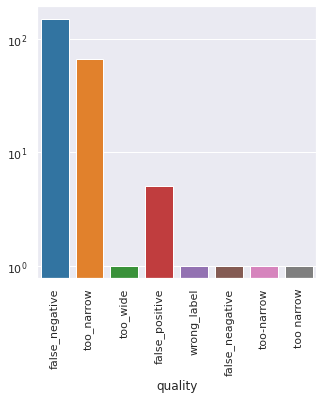

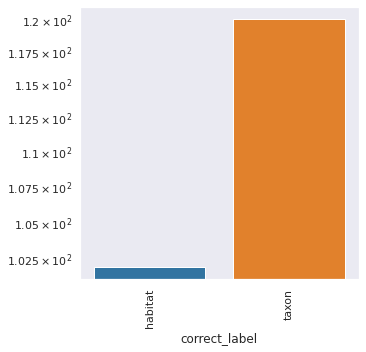

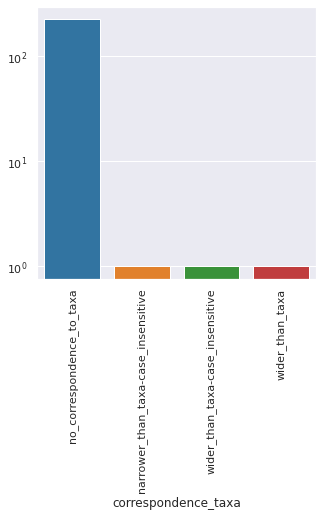

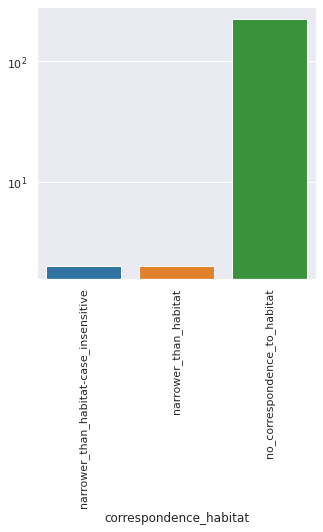

<Figure size 360x360 with 0 Axes>

In [34]:
c = 0
for v in data.columns:
    if (len(set(data[v])) >= 15 or
        v=='document_name' or
        v.startswith('comments') or
        v.startswith('possible')):
        continue
    c += 1

    sns.set(font_scale=1)
    plot(data=data, x=v, type='count', yscale='log')

plt.subplots_adjust(right=1)
plt.show()

## Solutions

*solution labelling meaning:*

(TODO add rule for latin ending?)

- `add_concept_or_synonym`
    
    to be checked manually, whether the lexeme represents a synonym of an already existing concept or a new concept on its own.

- `add_concept`

- `taxon_autocorrector`

    An autocorrector specialised on taxa needs to be implemented.

- `general_autocorrector`

    A general autocorrector could correct vernacular names.

- `anaphora_resolution`

    An anaphora resolution system needs to be applied.

In [8]:
def propose_solution(df):
    df.loc[ # for taxa with text extraction issues, an autocorrector should be applied
        df['supposed_cause'].str.contains('text_extraction_issue', na=False) &
        df['correct_label'].str.contains('habitat', na=False),
        'possible_solution'] += 'general_autocorrector,'
    
    df.loc[ # for taxa with text extraction issues, an autocorrector for taxa should be developed
        df['supposed_cause'].str.contains('text_extraction_issue', na=False) &
        df['correct_label'].str.contains('taxa', na=False),
        'possible_solution'] += 'taxon_autocorrector,'

    # an anaphora resolution system should be put into place to resolve unrecognised anaphora cases
    df.loc[df['supposed_cause'].str.contains('anaphora', na=False), 'possible_solution'] += 'anaphora_resolution,'
    
    '''   # not recognised and not corresponding to a taxon
    df.loc[
        df['quality'].str.contains('false_negative', na=False) &
        df['correspondence_taxa'].str.contains('no_correspondence_to_taxa', na=False) &
        df['correspondence_habitat'].str.contains('no_correspondence_to_habitat', na=False) &
            'possible_solution'] = 'add_concept_or_synonym'
    df.loc[
        df['quality'].str.contains('too_narrow', na=False) &
        df['correspondence_taxa'].str.contains('no_correspondence_to_taxa', na=False) &
        df['correspondence_habitat'].str.contains('no_correspondence_to_habitat', na=False) &
        df['correct_label'].str.contains('taxa', na=False),
            'possible_solution'] = 'add_concept' # e.g. the unknown_term is a species unknown to the ontology or 
    df.loc[
        df['quality'].str.contains('too_narrow', na=False) &
        df['correspondence_taxa'].str.contains('no_correspondence_to_taxa', na=False) &
        df['correspondence_habitat'].str.contains('no_correspondence_to_habitat', na=False)&
        df['correct_label'].str.contains('habitat', na=False),
            'possible_solution'] = 'add_concept_or_synonim' # e.g. the unknown_term is a species unknown to the ontology
    '''
            # e.g. Lady's Finger | lady finger
    return df

data = propose_solution(data)

unsolved_data = data.loc[data['possible_solution'].isna()]
solved_data = data.loc[data['possible_solution'].notna()]
print(len(set(unsolved_data['problem'])))
set(unsolved_data['problem'])


23


{('false_negative',
  ('anaphora',),
  'habitat',
  'no_correspondence_to_taxa',
  'narrower_than_habitat-case_insensitive'),
 ('false_negative',
  ('anaphora',),
  'habitat',
  'no_correspondence_to_taxa',
  'no_correspondence_to_habitat'),
 ('false_negative',
  ('anaphora',),
  'taxon',
  'no_correspondence_to_taxa',
  'narrower_than_habitat'),
 ('false_negative',
  ('anaphora',),
  'taxon',
  'no_correspondence_to_taxa',
  'no_correspondence_to_habitat'),
 ('false_negative',
  ('nan',),
  'habitat',
  'no_correspondence_to_taxa',
  'no_correspondence_to_habitat'),
 ('false_negative',
  ('nan',),
  'taxon',
  'narrower_than_taxa-case_insensitive',
  'no_correspondence_to_habitat'),
 ('false_negative',
  ('nan',),
  'taxon',
  'no_correspondence_to_taxa',
  'no_correspondence_to_habitat'),
 ('false_negative',
  ('nan',),
  'taxon',
  'wider_than_taxa-case_insensitive',
  'no_correspondence_to_habitat'),
 ('false_negative',
  ('outdated_term',),
  'habitat',
  'no_correspondence_to_tax